<a href="https://colab.research.google.com/github/SantiagoJulioD/Trabajo_de_grado/blob/main/Relic_density/relic_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
## **A review of Dark Matter production mechanisms**

Santiago Julio Dávila

### **Introduction**


To study the evolution of different energy components in the Universe it is necessary to consider departures from thermal equilibrium. A rough criterion to establish the moment in which a species is no longer in thermal equilibrium, or _decouples_, is given in terms of the interaction rate of the particles, $\Gamma$ and the expansion rate of the universe, $H$:

$$\begin{align*}
\Gamma&\gtrsim H \text{ (coupled)}\\
\Gamma&\lesssim H \text{ (decoupled)},
\end{align*}$$

that is, the species decouples from the thermal bath when the Hubble expansion rate is higher than the interaction rate of the particles. In order to track the evolution of the number density of the particles of interest, we need an equation describing the evolution of phase space distribution, $f(x^\mu,p^\mu)$, of the particle. Said equation is known as the Boltzmann equation, which, in general can be written as

$$
\hat{\mathcal{L}}\{f\}=\mathcal{C}\{f\},
$$

where $\hat{\mathcal{L}}$ is the Liouville operator and $\mathcal{C}\{f\}$ is the collision term. The Liouville operator can be defined as a total derivative with respect to a parameter of a function whose variables can depend on that parameter implicitly. In classical mechanics, the parameter is usually the time, and the Liouville operator is generally applied over a function $f(\vec{x},\vec{v},t)$, hence the Liouville operator takes the form

$$
\hat{\mathcal{L}}_{c}=\dfrac{\partial}{\partial t}+\dot{\vec{x}}\cdot\nabla+\dot{\vec{v}}\cdot\nabla_{\vec{v}}.
$$

Extending this definition to general relativity is straightforward, choosing a parameter $\theta$ such that $\frac{\mathrm{d}x^\mu}{\mathrm{d}\theta}\equiv\dot{x}^\mu=p^\mu$ and considering functions of the type $f(x^\mu,p^\mu)$ that do not depend explicitly on said parameter, the Liouville operator is given by

$$
\hat{\mathcal{L}}=p^\mu\dfrac{\partial}{\partial x^\mu}-\Gamma^\mu_{\alpha\beta}p^\alpha p^\beta \dfrac{\partial}{\partial p^\mu}
$$

where we have used the geodesic equation $\dot{p}^\mu+\Gamma^\mu_{\alpha\beta}p^\alpha p^\beta=0$. The distribution functions of interest are homogeneous and isotropic in space, as determined by the Friedmann-Lemaître-Robertson-Walker (FLRW) metric: $f(x^\mu,p^\mu)=f(x^0,p^0)=f(t,E)$. With this metric, it is easy to verify that the Liouville operator is

$$
\hat{\mathcal{L}}\{f\}=E\dfrac{\partial f}{\partial t}-\dfrac{\dot{a}}{a}p^2\dfrac{\partial f}{\partial E}.
$$

The Boltzmann equation then is

$$
E\dfrac{\partial f}{\partial t}-Hp^2\dfrac{\partial f}{\partial E}=\mathcal{C}\{f\}.
$$

Integrating this equation over $\mathrm{d}\tilde{p}=\frac{g}{(2\pi)^3}\frac{\mathrm{d}^3\vec{p}}{E}$ and using the definition of number density

$$
n(t)=\dfrac{g}{(2\pi)^3}\int\mathrm{d}^3\vec{p}f(E,t),
$$

where $E$ is subject to the constraint $E²=m²+p²$, the Boltzmann equation reads

$$
\dfrac{\mathrm{d}n}{\mathrm{d}t}+3Hn=\dfrac{g}{(2\pi)^3}\int\mathrm{d}^3\vec{p}\dfrac{\mathcal{C}\{f\}}{E}.
$$

Defining $Y=n/s$ and $x=m/T$, where 

$$s=\dfrac{2\pi²}{45}g_\star(T)T³$$

is the entropy density satisfying entropy conservation $sa³=constant$, hence, ignoring the temperature dependence of the relativistic degrees of freedom, $g_\star$, $\dot{s}=-3Hs$. Differentiating $Y$ with respect to time

$$
\dot{Y}=\dfrac{\dot{n}}{s}-\dfrac{n\dot{s}}{s²}=\dfrac{\dot{n}+3Hn}{s}.
$$

From entropy conservation, using the functional form of $s$ and neglecting the temperature dependence of $g_\star$, we can also deduce $aT=constant$, and so, $\dot{T}=-HT$. Using the chain rule, one could write the time derivative in terms of the variable $x$: $\frac{\mathrm{d}}{\mathrm{d}t}=\frac{\mathrm{d}T}{\mathrm{d}t}\frac{\mathrm{d}x}{\mathrm{d}T}\frac{\mathrm{d}}{\mathrm{d}x}=Hx\frac{\mathrm{d}}{\mathrm{d}x}$, so the Boltzmann equation can be written as

$$
\dfrac{\mathrm{d}Y}{\mathrm{d}x}=\dfrac{1}{Hxs}\dfrac{g}{(2\pi)^3}\int\mathrm{d}^3\vec{p}\dfrac{\mathcal{C}\{f\}}{E}.
$$

Considering a reaction $\underbrace{\psi+a+b+...}_{in}\rightleftharpoons \underbrace{i+j+...}_{out}$, where $\psi$ is the species of interest. The collision term for a process like this is given by

$$\begin{align*}
\int\mathcal{C}\{f\}\mathrm{d}\tilde{p}_\psi=&-\int\left(\prod_{in}\mathrm{d}\tilde{p}_k\right)\left(\prod_{out}\mathrm{d}\tilde{p}_k\right)(2\pi)^4\delta⁴(p_{in}-p_{out})\times\\
&\times\left[|M|²_\rightarrow\left(\prod_{in}f_k\right)\left(\prod_{out}(1\pm f_k)\right)-|M|²_\leftarrow\left(\prod_{out}f_k\right)\left(\prod_{in}(1\pm f_k)\right)\right],
\end{align*}$$

which can be simplified by considering $CP$ invariance, which implies the invariant transition amplitude for the forward reaction is equal to that of the reverse reaction: $|M|²_\rightarrow=|M|²_\leftarrow=|M|²$, and by ignoring the blocking and stimulated emission factors $1\pm f_k\simeq 1$, leading to the Boltzmann equation

$$
\dfrac{\mathrm{d}n}{\mathrm{d}t}+3Hn=-\int\left(\prod_{in}\mathrm{d}\tilde{p}_k\right)\left(\prod_{out}\mathrm{d}\tilde{p}_k\right)(2\pi)^4\delta⁴(p_{in}-p_{out})|M|²\left[\left(\prod_{in}f_k\right)-\left(\prod_{out}f_k\right)\right].
$$

We shall focus our attention in some particle-like dark matter (DM) candidates, and the solutions to Boltzmann equation in said context. The first DM model to be analyzed are _Weakly Interacting Massive Particles_, or WIMPs, which decouple from the thermal bath mainly via $2\rightarrow2$ annihilations into standard model (SM) particles, and satisfy the relic density constraint from observational data $\Omega_0 h²\simeq0.12$; there are other alternate mechanisms from which WIMPs freeze-out, such as semi-annihilation, which will be discussed here. Another mechanism that can produce the observed relic density is the freeze-in mechanism, in which the coupling between the dark sector and the visible sector is small enough to prevent the dark sector to be in thermal equilibrium with the dark sector, and the relic abundance freezes to a constant value after the densities of the visible particles producing the dark particles becomes Boltzmann-suppressed; dark particles produced by this mechanism are called _Frozen-In_ or _Feebly Interacting Massive Particles_, FIMPs for short. If we assume very small DM-SM interactions, self-interactions within the dark sector become significant, in particular, number-changing processes, such as $3\to2$, which we will study here, and $4\to2$.

In [175]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import differential_evolution, newton
from scipy.integrate import solve_ivp, quad
from scipy.special import kn
from astropy import constants as ct
import pandas as pd
from ipywidgets import interact,fixed,widgets,interactive
import warnings 
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 
pd.set_option('display.max_rows', 500)

### **Boltzmann equation for WIMPs**

We will first consider the WIMP annihilation into SM particles $DM+DM\rightleftharpoons SM+SM$ happenning during the radiation domination epoch, described by the Friedmann equation

$$
H(T)=\sqrt{\dfrac{\rho_R(T)}{3M_P²}},
$$

where $M_P\approx 2.4\times10¹⁸\text{ GeV}$ is the reduced Planck mass, $g_\star=106.75$, and the SM radiation energy density is given by

$$
\rho_R(T)=\dfrac{\pi²}{30}g_\star T⁴.
$$

The collision term for this process is given by 

$$
-\int\mathrm{d}\tilde{p}_1\mathrm{d}\tilde{p}_2\mathrm{d}\tilde{p}_3\mathrm{d}\tilde{p}_4(2\pi)⁴\delta⁴(p_1+p_2-p_3-p_4)|M|²(f_1f_2-f_3^{eq}f_4^{eq}),
$$

where 1 and 2 represent the DM particles on the left side of the reaction and 3 and 4 represent the SM particles on the right side of the reaction, which are in thermal equilibrium, thus, the superindex "eq" on $f_3^{eq}f_4^{eq}$. The Dirac delta accounts for the conservation of the 4-momentum in the process, particularly, the conservation of energy. We assume that the equilibrium distributions are Maxwell-Boltzmann distributions without chemical potential: $f_i^{eq}\sim \exp(-E_i/T)$ and the non-equilibrium distributions are approximately proportional to the equilibrium distributions $f_i\approx\left(\frac{n_i}{n_i^{eq}}f_i^{eq}\right)$. The SM particles distributions is then

$$
f_3^{eq}f_4^{eq}=\exp(-(E_3+E_4)/T)=\exp(-(E_1+E_2)/T)=f_1^{eq}f_2^{eq}
$$

Replacing in the collision term, we get the expression

$$
-(n_1n_2-n_1^{eq}n_2^{eq})\dfrac{1}{n_1^{eq}n_2^{eq}}\int\mathrm{d}\tilde{p}_1\mathrm{d}\tilde{p}_2\mathrm{d}\tilde{p}_4\mathrm{d}\tilde{p}_3(2\pi)⁴\delta⁴(p_1+p_2-p_3-p_4)|M|²f_1^{eq}f_2^{eq}=-\langle\sigma v\rangle(n²-n_{eq}²),
$$

where the thermally-averaged cross section, $\langle\sigma v\rangle$, is defined as the integral in the previous equation and we have used the fact that there is no asymmetry between the DM species involved in the reaction, hence $n_1=n_2=n$. $n_{eq}$ is easily found considering that the equilibrium distributions are Maxwell-Boltzmann distributions:

$$
n_{eq} = \dfrac{g}{2\pi^2}m^2TK_2\left(\dfrac{m}{T}\right)
$$

 Using the definition of $Y$, the Boltzmann equation becomes 

$$
\dfrac{\mathrm{d}Y}{\mathrm{d}x}=-\dfrac{\langle\sigma v\rangle s}{Hx}(Y²-Y_{eq}²)
$$

and the relic abundance $\Omega_0=mY_0s_0/3H_0²M_P²$ is given by:

$$
\Omega_{0}h^2=\dfrac{Y_0ms_0}{3M_P^2(2.13\times 10^{-42}\text{ GeV})^2},
$$

where the subscript 0 represents the current value of the quantity in question.

In [2]:
# Constants
gstar = 106.75
MP = 2.4e18 #GeV

In [3]:
# Values today
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3

In [4]:
scan=False

In [5]:
def Yeq(x,mass,g):
    '''
    Equilibrium abundance.
    ---
    INPUT
     x: variable m/T
     mass: mass of the particle in GeV
     g: degrees of freedom

    OUTPUT:
     Y_eq
    '''
    neq = g/(2*np.pi**2)*mass**3/x*kn(2,x)
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    return neq/s

def WIMPs(x,Y,mass,sigma,g):
    '''
    Boltxmann equation for WIMPs.
    ---
    INPUT
     x: independent variable, m/T
     Y: dependent variable, abundance
     mass: mass of the particle in GeV
     sigma: thermally averaged cross section in GeV^-2
     g: degrees of freedom of the particle

    OUTPUT
     dY/dx
    '''
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Yeq(x,mass,g)**2)
    return dYdx



In [6]:
def Omega(m,sigma,model=WIMPs,g=2,method='BDF'):
    '''
    Relic abundance from the numeric solution of Boltzmann equation.
    ---
    INPUT
     m: mass of the particle in GeV
     sigma: thermally averaged cross section in GeV^-2 (GeV^-5 for SIMPs)
     model: Boltzmann equation to be solved
     g: degrees of freedom of the particle (2 by default)
    OUTPUT
     Ω_0h²
    '''
    m = 10.**m
    sigma = 10.**sigma
    xini = 0.1
    xfin = 1e4
    if model.__name__ == 'FIMPs':
        Yini = 0
    else:
        Yini = Yeq(xini, m, g)
    sol = solve_ivp(model, [xini,xfin], [Yini,], method=method, rtol=1e-8, atol=1e-10, args=(m,sigma,g))
    Y0 = sol.y[0][-1]
    s0 = 2*np.pi**2/45*gstars0*T0**3
    Omegah2 = Y0*m*s0/(3*MP**2*(2.13e-42)**2)
    if Omegah2 > 0:
        return Omegah2
    else:
        return 0

Omega = np.vectorize(Omega)

In [7]:
def graf1(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    Yfin = 4.3e-10/mass
    sol = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),g=g):.3f}',color='r')
    plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
    plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    #plt.ylim(2e-8,1e-2)
    plt.title('Boltzmann equation for WIMPs')
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=3,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-15, max=-7,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=1, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot1 = interactive(graf1, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot1

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-3.0, step=0.0001), FloatLo…

### Exploring the parameter space

In [8]:
# Confidence level etc
alpha = 0.05
beta = 1. - alpha
critical_chi_sq = chi2.isf(alpha, 2)
critical_loglike = 0.5 * critical_chi_sq
min_chi_sq = 0.

In [9]:
# Scan settings
n_random_samples = int(1e7)
dim = 4
min_ = -5.
max_ = 5.
seed = 127


Likelihood function $\propto\mathcal{N}(\Omega_{obs},\Sigma)$. Thus, 

$$
\chi^2=\left(\dfrac{\Omega-\Omega_{obs}}{\Sigma}\right)^2
$$

with $\Omega_{obs}=0.12$ and $\Sigma=\sqrt{(0.1\Omega)^2+(0.001)^2}$

In [10]:
Omega_0 = 0.12
Sigma_th_rel = 0.1
Sigma_0 = 0.001

In [11]:
def chi_square(Omega):
    """
    Returns chi² function
    """
    Sigma = ((Sigma_th_rel*Omega)**2+(Sigma_0)**2)**0.5
    return ((Omega-Omega_0)/Sigma)**2

def loglike(Omega):
    """
    Returns log(L)
    """
    return -0.5*chi_square(Omega)

def samples_inside(x, chi_sq):
    """
    @returns Points from within delta chi-squared contour
    """
    delta_chi_sq = chi_sq - min_chi_sq
    inside = delta_chi_sq <= critical_chi_sq
    return x[:, inside]

In [12]:
def loglike_pars(P,model,g):
    m,sigma = P
    return loglike(Omega(m,sigma,model=model,g=g))
def chi_square_pars(P,model,g):
    m,sigma = P
    return chi_square(Omega(m,sigma,model=model,g=g))

In [13]:
bound_m = (-3,3)
bound_sigma = (-15,-7)
g = 1

In [14]:
def de_scan(model,bound_m,bound_sigma,g,round_to_nearest=None):
    """
    @returns Points from within delta chi-squared contour from differential evolution
    and number of calls
    """
    bounds = [bound_m,bound_sigma]
    x = []
    chi_sq = []

    def objective(x_):
        """
        @returns Objective for DE that saves chi-squared and parameters
        """
        chi_sq_ = chi_square_pars(x_,model,g)
        chi_sq.append(chi_sq_)
        x.append(x_)
        return chi_sq_

    differential_evolution(objective, bounds,
                           strategy='rand1bin', maxiter=None,
                           popsize=50, tol=0.01, mutation=(0.7, 1.99999), recombination=0.15,
                           polish=False,seed=seed)

    if round_to_nearest is not None:
        len_x = len(x)
        keep_n = len_x - (len_x % round_to_nearest)
        x = x[:keep_n]
        chi_sq = chi_sq[:keep_n]

    return samples_inside(np.array(x).T, np.array(chi_sq)), len(x)

In [15]:
ms_W = np.linspace(*bound_m)
sigmas_W = np.linspace(*bound_sigma)

Ms_W, Sigmas_W = np.meshgrid(ms_W,sigmas_W)
Os_W = Omega(Ms_W,Sigmas_W,g=g)

In [16]:
def Omegah2_analytic(mass,sigma,n=0):
    A = np.log(0.038*(n+1)*g/(gstar**0.5)*(8*np.pi)**0.5*MP*mass*sigma)
    xf = A-(n+0.5)*np.log(A)
    omh = 1.07e9*(n+1)*xf**(n+1)/((gstar/gstar**0.5)*(8*np.pi)**0.5*MP*sigma)
    return omh

Omegah2_analytic = np.vectorize(Omegah2_analytic)

In [17]:
def obtain_optimal_params(model,bound_m,bound_sigma,g,path=None,descan=False):
    if descan:
        np.random.seed(seed)

        print('Running de_scan')
        t0 = time.time()
        x,calls = de_scan(model,bound_m,bound_sigma,g,round_to_nearest=1000)
        de_time = time.time() - t0
        print('Time = ', de_time)

        omegas_chi2 = Omega(x[0],x[1],model=model)

        df = pd.DataFrame()
        df['log(m)'] = pd.Series(x[0])
        df['log(sigma*v)'] = pd.Series(x[1])
        df['Omegah2'] = pd.Series(omegas_chi2)

        filename = 'optimal_params_'+model.__name__+'.csv'

        df.to_csv(filename,index=False)

        return df

    else:
        df = pd.read_csv(path)
        return df

        

In [18]:
Os_an = Omegah2_analytic(10.**Ms_W,10.**Sigmas_W)

In [19]:
if scan:
    df_WIMP = obtain_optimal_params(WIMPs,bound_m,bound_sigma,g,descan=scan)
else:
    path_WIMP = 'https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/Relic_density/optimal_params_WIMPs.csv'
    df_WIMP = obtain_optimal_params(WIMPs,bound_m,bound_sigma,g,descan=scan,path=path_WIMP)

Plotting de_scan


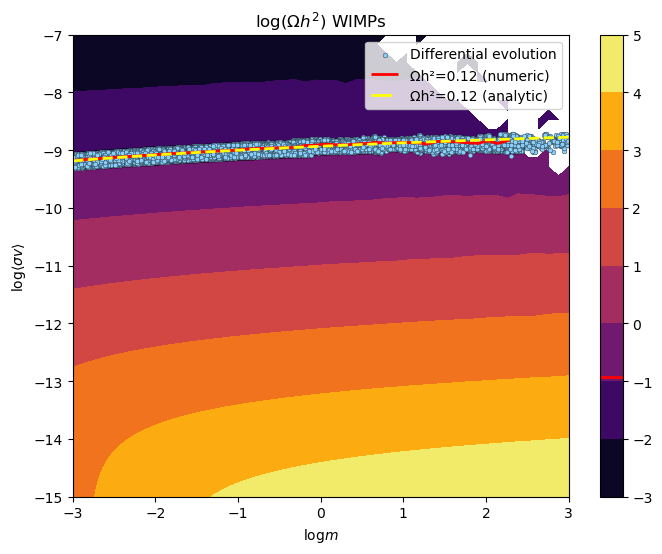

In [133]:
print('Plotting de_scan')
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms_W,Sigmas_W,np.log10(Os_W),cmap='inferno',)
de_scatter = ax.scatter(df_WIMP['log(m)'], df_WIMP['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
CS2l = ax.contour(Ms_W,Sigmas_W,np.log10(Os_an),levels=[np.log10(0.12),],colors='yellow',linestyles='dashed',linewidths=2)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

ax.legend()

h0,_ = de_scatter.legend_elements(prop='sizes',color=de_scatter.cmap(1.5))
h1,_ = CSl.legend_elements()
h2,_ = CS2l.legend_elements()

ax.legend([de_scatter]+h1+h2,['Differential evolution','Ωh²=0.12 (numeric)','Ωh²=0.12 (analytic)'])

#ax.add_artist(leg2)

ax.set_title(r'$\mathrm{log}(\Omega h^2)$ WIMPs')
#ax.set_ylim((-13,-8))
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\langle\sigma v\rangle$')
plt.savefig('omegah2_WIMPs.pdf')
plt.show()

In [155]:
p_W = CSl.collections[0].get_paths()[0]
v_W = p_W.vertices
v_W = pd.DataFrame(v_W)

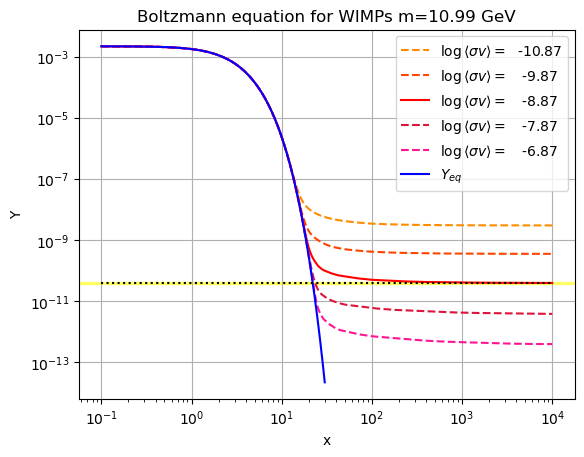

In [161]:
xini = 0.1
xfin = 1e4
m_exp, s_exp = v_W[(v_W[0]>0.9) & (v_W[0]<1.1)].values[0]
mass = 10.**m_exp
sigma = 10.**s_exp
Yini = Yeq(xini,mass,g)
xss = np.linspace(xini,30,1000)
Yfin = 4.3e-10/mass
sol = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
sol_1 = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*10,g))
sol_2 = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*100,g))
sol_3 = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/10,g))
sol_4 = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/100,g))
plt.loglog(sol_4.t,sol_4.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-2),color='darkorange',linestyle='--')
plt.loglog(sol_3.t,sol_3.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-1),color='orangered',linestyle='--')
plt.loglog(sol.t,sol.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)),color='r')
plt.loglog(sol_1.t,sol_1.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+1),color='crimson',linestyle='--')
plt.loglog(sol_2.t,sol_2.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+2),color='deeppink',linestyle='--')
plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
#plt.ylim(2e-8,1e-2)
plt.title(f'Boltzmann equation for WIMPs m={mass:.2f} GeV')
plt.xlabel('x')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.savefig('Boltzmann_WIMP.pdf')
plt.show()

### Parametrization of WIMP cross section

In [21]:
def WIMPs_par(x,Y,mass,alpha,g):
    sigma = alpha**2/mass**2
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Yeq(x,mass,g)**2)
    return dYdx

In [22]:
def graf5(mass,alpha,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    Yfin = 4.3e-10/mass
    sol = solve_ivp(WIMPs_par, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,alpha,g))
    sigma = alpha**2/mass**2
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma)):.3f}',color='r')
    plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
    plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    #plt.ylim(2e-8,1e-2)
    plt.title(r"Parametrization of WIMP's cross section $\langle\sigma v\rangle=\dfrac{\alpha^2}{m^2}$")
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=5,
                                  step=0.0001, description='mass')
slider_alpha = widgets.FloatLogSlider(value=1e-2, base=10, min=-5, max=0,
                                  step=0.1, description='alpha')
slider_g = widgets.FloatSlider(value=1, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot5 = interactive(graf5, mass=slider_mass, alpha=slider_alpha, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot5

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=5.0, min=-3.0, step=0.0001), FloatLo…

In [23]:
Omega_par = lambda m,alpha: Omegah2_analytic(10.**m,(10.**alpha/10.**m)**2)

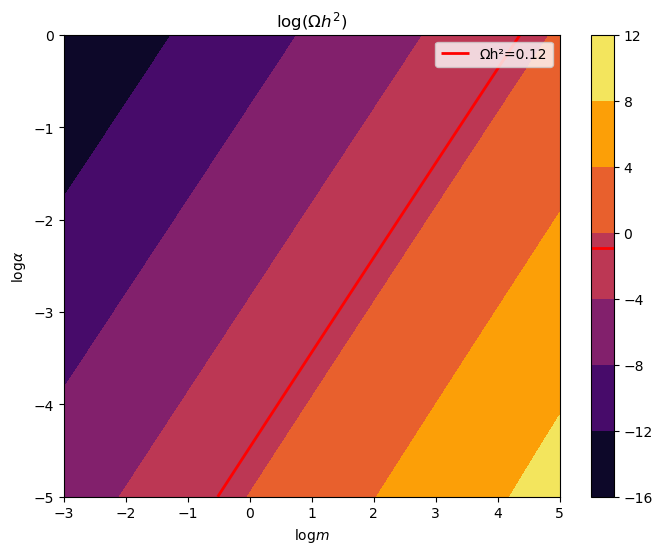

In [24]:
ms = np.linspace(-3,5)
alphas = np.linspace(-5,0)

Ms, Alphas = np.meshgrid(ms,alphas)

Os_par = Omega_par(Ms,Alphas)

fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Alphas,np.log10(Os_par),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='r',linestyles='solid',linewidths=2)
ax.set_title(r'$\mathrm{log}(\Omega h^2)$')
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\alpha$')
h1,_ = CSl.legend_elements()
ax.legend(h1,['Ωh²=0.12'])
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

In [25]:
p = CSl.collections[0].get_paths()[0]
v = p.vertices
d = pd.DataFrame(v,columns=['logm','loga'])
Mmax = 10.**d[d['loga']==0]['logm'].values[0]

print(f'The maximal mass value compatible with perturbativity is {Mmax:.2f} GeV')

The maximal mass value compatible with perturbativity is 22885.51 GeV


### FIMPs

In [26]:
def FIMPs(x,Y,mass,sigma,g):
    a = 45/(4*np.pi**4*gstar)
    b = (2/15)*(10*gstar)**0.5*MP
    return sigma*a**2*b*mass*g**2*(x*kn(2,x))**2

FIMPs = np.vectorize(FIMPs)

In [27]:
def FIMPs_an(x,mass,sigma,g,xini=0.1,integval=None):
    a = 45/(4*np.pi**4*gstar)
    b = (2/15)*(10*gstar)**0.5*MP
    if integval:
        integ = integval
    else:
        integ = quad(lambda x:(x*kn(2,x))**2,xini,x)[0]
    return sigma*a**2*b*mass*g**2*integ

FIMPs_an = np.vectorize(FIMPs_an)

In [28]:
def graf4(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = 0.
    xss = np.linspace(xini,30,1000)

    xs = np.logspace(np.log10(xini),np.log10(xfin),1000)
    an = FIMPs_an(xs,mass,sigma,g,xini)

    Yfin = 4.3e-10/mass
    sol = solve_ivp(FIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),model=FIMPs,g=g):.3f}',color='r')
    plt.loglog(xss,Yeq(xss,mass,g),color='b',label=r'$Y_{eq}$')
    plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    #plt.ylim(2e-8,1e-2)
    plt.title("Boltzmann equation for FIMPs")
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-6, max=3,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-32, max=-12,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=1, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot4 = interactive(graf4, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot4

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-6.0, step=0.0001), FloatLo…

In [29]:
ms_F = np.linspace(-6,3)
sigmas_F = np.linspace(-32,-12)

Ms_F, Sigmas_F = np.meshgrid(ms_F,sigmas_F)

In [30]:
Om_FIMP = Omega(Ms_F,Sigmas_F,model=FIMPs,g=g)
Om_FIMP_an = FIMPs_an(np.inf,10.**Ms_F,10.**Sigmas_F,g=g)*10.**Ms_F*s0/(3*MP**2*(2.13e-42)**2)

In [31]:
bound_m_F = (-6,3)
bound_sigma_F = (-32,-12)

In [32]:
if scan:
    df_FIMP = obtain_optimal_params(FIMPs,bound_m_F,bound_sigma_F,g,descan=scan)
else: 
    path_FIMP = 'https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/Relic_density/optimal_params_FIMPs.csv'
    df_FIMP = obtain_optimal_params(WIMPs,bound_m,bound_sigma,g,descan=scan,path=path_FIMP)

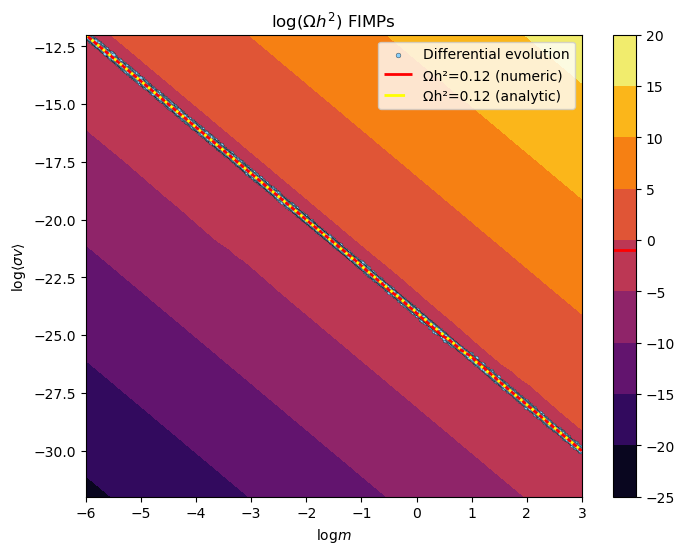

In [165]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms_F,Sigmas_F,np.log10(Om_FIMP),cmap='inferno',)
de_scatter = ax.scatter(df_FIMP['log(m)'], df_FIMP['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='r',linestyles='solid',linewidths=2)
CSl2 = ax.contour(Ms_F,Sigmas_F,np.log10(Om_FIMP_an),levels=[np.log10(0.12),],colors='yellow',linestyles='dotted',linewidths=2)
h0,_ = de_scatter.legend_elements(prop='sizes',color=de_scatter.cmap(1.5))
h1,_ = CSl.legend_elements()
h2,_ = CS2l.legend_elements()
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

ax.legend([de_scatter]+h1+h2,['Differential evolution','Ωh²=0.12 (numeric)','Ωh²=0.12 (analytic)'])

#ax.add_artist(leg2)

ax.set_title(r'$\mathrm{log}(\Omega h^2)$ FIMPs')
#ax.set_ylim((-13,-8))
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\langle\sigma v\rangle$')
plt.savefig('omegah2_FIMPs.pdf')
plt.show()

In [166]:
p_F = CSl.collections[0].get_paths()[0]
v_F = p_F.vertices
v_F = pd.DataFrame(v_F)

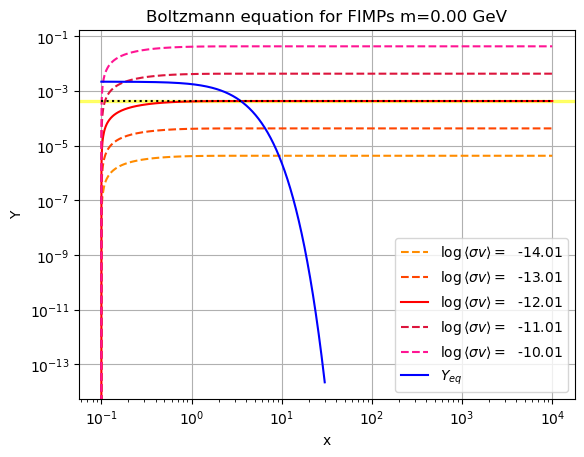

In [168]:
xini = 0.1
xfin = 1e4
m_exp, s_exp = v_F[(v_W[0]>0.9) & (v_F[0]<1.1)].values[0]
mass = 10.**m_exp
sigma = 10.**s_exp
Yini = 0.
xss = np.linspace(xini,30,1000)
Yfin = 4.3e-10/mass
sol = solve_ivp(FIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
sol_1 = solve_ivp(FIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*10,g))
sol_2 = solve_ivp(FIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*100,g))
sol_3 = solve_ivp(FIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/10,g))
sol_4 = solve_ivp(FIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/100,g))
plt.loglog(sol_4.t,sol_4.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-2),color='darkorange',linestyle='--')
plt.loglog(sol_3.t,sol_3.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-1),color='orangered',linestyle='--')
plt.loglog(sol.t,sol.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)),color='r')
plt.loglog(sol_1.t,sol_1.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+1),color='crimson',linestyle='--')
plt.loglog(sol_2.t,sol_2.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+2),color='deeppink',linestyle='--')
plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
#plt.ylim(2e-8,1e-2)
plt.title(f'Boltzmann equation for FIMPs m={mass:.2f} GeV')
plt.xlabel('x')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.savefig('Boltzmann_FIMP.pdf')
plt.show()

### WIMPs semi-annihilation and SIMPs

In [34]:
def WIMPs_SA(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Y*Yeq(x,mass,g))
    return dYdx

def SIMPs(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s**2/(x*H)*(Y**3 - Y**2*Yeq(x,mass,g))
    return dYdx

In [35]:
def graf2(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    Yfin = 4.3e-10/mass
    sol = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),model=SIMPs,g=g):.3}',color='r')
    plt.loglog(xss,Yeq(xss,mass,g),color='b',label=r'$Y_{eq}$')
    plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    #plt.ylim(2e-8,1e-2)
    plt.title("Boltzmann equation for SIMPs")
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=0.975, base=10, min=-3, max=4,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e3, base=10, min=-3, max=7,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=1, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot2 = interactive(graf2, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot2

interactive(children=(FloatLogSlider(value=0.975, description='mass', min=-3.0, step=0.0001), FloatLogSlider(v…

In [36]:
bound_m_S = (-4,3)
bound_sigma_S = (-3,8)

In [37]:
if scan:
    df_SIMP = obtain_optimal_params(SIMPs,bound_m_S,bound_sigma_S,g,descan=scan)
else:
    path_SIMP = 'https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/Relic_density/optimal_params_SIMPs.csv'
    df_SIMP = obtain_optimal_params(WIMPs,bound_m,bound_sigma,g,descan=False,path=path_SIMP)

In [39]:
ms_S = np.linspace(-6,3)
sigmas_S = np.linspace(-3,8)

Ms_S, Sigmas_S = np.meshgrid(ms_S,sigmas_S)

Om_SIMP = Omega(Ms_S,Sigmas_S,model=SIMPs,g=g)

In [40]:
def Omega0_SIMP(m,sigma,g,const):
    alpha = 2*np.pi**2/45*gstar
    beta = (np.pi**2/(90*MP**2)*gstar)**0.5
    lam = sigma*alpha**2/beta*m**4
    k = 0.145*g/gstar
    func = lambda xf_: np.exp(-2*xf_)*(k**2*lam*const)-xf_**2
    xf = newton(func,10,maxiter=2000)
    Yinf = (2/lam)**0.5*xf**2
    return Yinf*m*s0/(3*MP**2*(2.13e-42)**2)

Omega0_SIMP = np.vectorize(Omega0_SIMP)

In [41]:
Om_th_S = Omega0_SIMP(10.**Ms_S,10.**Sigmas_S,2,5)

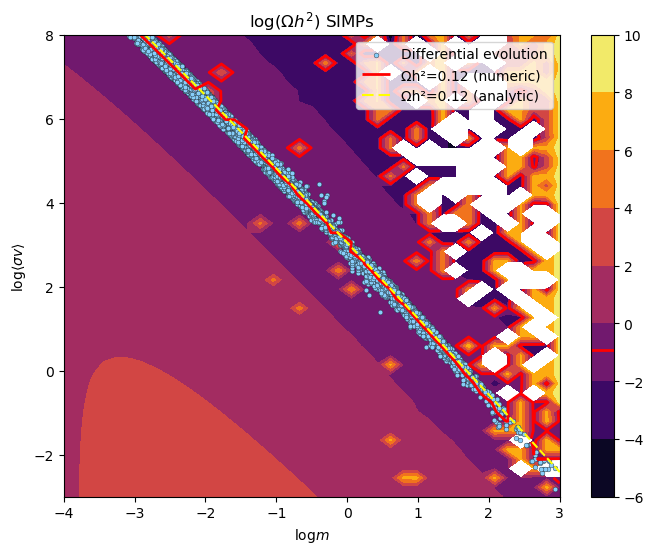

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms_S,Sigmas_S,np.log10(Om_SIMP),cmap='inferno',)
de_scatter = ax.scatter(df_SIMP['log(m)'], df_SIMP['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='r',linestyles='solid',linewidths=2)
CS2l = ax.contour(Ms_S,Sigmas_S,np.log10(Om_th_S),levels=[np.log10(0.12),],colors='yellow')
ax.set(xlim=(-4,3))
h0,_ = de_scatter.legend_elements(prop='sizes',color=de_scatter.cmap(1.5))
h1,_ = CSl.legend_elements()
h2,_ = CS2l.legend_elements()
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

ax.legend([de_scatter]+h1+h2,['Differential evolution','Ωh²=0.12 (numeric)','Ωh²=0.12 (analytic)'])

#ax.add_artist(leg2)

ax.set_title(r'$\mathrm{log}(\Omega h^2)$ SIMPs')
#ax.set_ylim((-13,-8))
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\langle\sigma v\rangle$')
plt.savefig('omegah2_SIMPs.pdf')
plt.show()


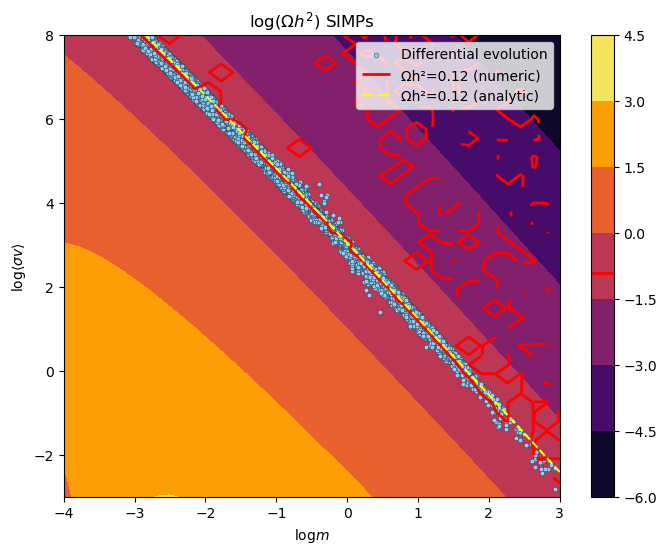

In [170]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms_S,Sigmas_S,np.log10(Om_th_S),cmap='inferno',)
de_scatter = ax.scatter(df_SIMP['log(m)'], df_SIMP['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(Ms_S,Sigmas_S,np.log10(Om_SIMP),levels=[np.log10(0.12),],colors='r',linestyles='solid',linewidths=2)
CS2l = ax.contour(CS,levels=[np.log10(0.12),],colors='yellow')
ax.set(xlim=(-4,3))
h0,_ = de_scatter.legend_elements(prop='sizes',color=de_scatter.cmap(1.5))
h1,_ = CSl.legend_elements()
h2,_ = CS2l.legend_elements()
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

ax.legend([de_scatter]+h1+h2,['Differential evolution','Ωh²=0.12 (numeric)','Ωh²=0.12 (analytic)'])

#ax.add_artist(leg2)

ax.set_title(r'$\mathrm{log}(\Omega h^2)$ SIMPs')
#ax.set_ylim((-13,-8))
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\langle\sigma v\rangle$')
plt.savefig('omegah2_SIMPs_th.pdf')
plt.show()


In [186]:
p_S = CSl.collections[0].get_paths()[0]
v_S = p_S.vertices
v_S = pd.DataFrame(v_S)

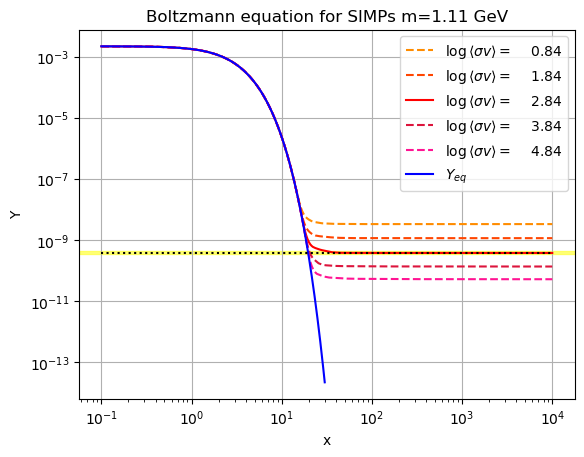

In [188]:
xini = 0.1
xfin = 1e4
m_exp, s_exp = v_S[(v_S[0]>-0.1) & (v_S[0]<0.1)].values[1]
mass = 10.**m_exp
sigma = 10.**s_exp
Yini = Yeq(xini,mass,g)
xss = np.linspace(xini,30,1000)
Yfin = 4.3e-10/mass
sol = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
sol_1 = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*10,g))
sol_2 = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*100,g))
sol_3 = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/10,g))
sol_4 = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/100,g))
plt.loglog(sol_4.t,sol_4.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-2),color='darkorange',linestyle='--')
plt.loglog(sol_3.t,sol_3.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-1),color='orangered',linestyle='--')
plt.loglog(sol.t,sol.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)),color='r')
plt.loglog(sol_1.t,sol_1.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+1),color='crimson',linestyle='--')
plt.loglog(sol_2.t,sol_2.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+2),color='deeppink',linestyle='--')
plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
#plt.ylim(2e-8,1e-2)
plt.title(f'Boltzmann equation for SIMPs m={mass:.2f} GeV')
plt.xlabel('x')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.savefig('Boltzmann_SIMP.pdf')
plt.show()

In [38]:
def graf3(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    Yfin = 4.3e-10/mass
    sol = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),g=g,model=WIMPs_SA):.3f}',color='r')
    plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
    plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    #plt.ylim(2e-8,1e-2)
    plt.title("Boltzmann equation for WIMPs semi-annihilation")
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-4, max=2,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-10, max=-3,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot3 = interactive(graf3, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot3

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=2.0, min=-4.0, step=0.0001), FloatLo…

In [44]:
bound_m = (-3,3)
bound_sigma = (-15,-7)

In [63]:
ms_Wsa = np.linspace(*bound_m)
sigmas_Wsa = np.linspace(*bound_sigma)

Ms_Wsa, Sigmas_Wsa = np.meshgrid(ms_Wsa,sigmas_Wsa)
Os_Wsa = Omega(Ms_Wsa,Sigmas_Wsa,g=g,model=WIMPs_SA)
Os_an_Wsa = Omegah2_analytic(10.**Ms_W,10.**Sigmas_W)

In [46]:
if scan:
    df_WIMPSA = obtain_optimal_params(WIMPs_SA,bound_m,bound_sigma,g,descan=scan)
else:
    path_WIMPSA = 'https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/Relic_density/optimal_params_WIMPs_SA.csv'
    df_WIMPSA = obtain_optimal_params(WIMPs_SA,bound_m,bound_sigma,g,descan=scan,path=path_WIMPSA)

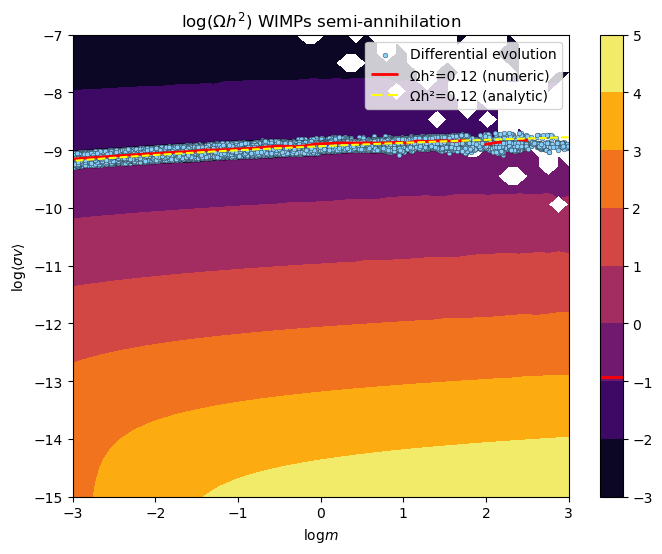

In [189]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms_Wsa,Sigmas_Wsa,np.log10(Os_Wsa),cmap='inferno',)
de_scatter = ax.scatter(df_WIMPSA['log(m)'], df_WIMPSA['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='r',linestyles='solid',linewidths=2)
CS2l = ax.contour(Ms_Wsa,Sigmas_Wsa,np.log10(Os_an_Wsa),levels=[np.log10(0.12),],colors='yellow')
h0,_ = de_scatter.legend_elements(prop='sizes',color=de_scatter.cmap(1.5))
h1,_ = CSl.legend_elements()
h2,_ = CS2l.legend_elements()
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

ax.legend([de_scatter]+h1+h2,['Differential evolution','Ωh²=0.12 (numeric)','Ωh²=0.12 (analytic)'])

#ax.add_artist(leg2)

ax.set_title(r'$\mathrm{log}(\Omega h^2)$ WIMPs semi-annihilation')
#ax.set_ylim((-13,-8))
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\langle\sigma v\rangle$')
plt.savefig('omegah2_WIMPs_SA.pdf')
plt.show()


In [190]:
p_Wsa = CSl.collections[0].get_paths()[0]
v_Wsa = p_Wsa.vertices
v_Wsa = pd.DataFrame(v_Wsa)

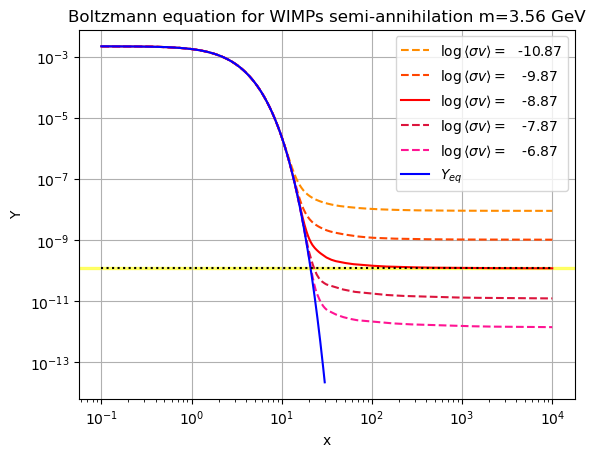

In [194]:
xini = 0.1
xfin = 1e4
m_exp, s_exp = v_Wsa[(v_Wsa[0]>0.4) & (v_Wsa[0]<0.6)].values[0]
mass = 10.**m_exp
sigma = 10.**s_exp
Yini = Yeq(xini,mass,g)
xss = np.linspace(xini,30,1000)
Yfin = 4.3e-10/mass
sol = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
sol_1 = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*10,g))
sol_2 = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma*100,g))
sol_3 = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/10,g))
sol_4 = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma/100,g))
plt.loglog(sol_4.t,sol_4.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-2),color='darkorange',linestyle='--')
plt.loglog(sol_3.t,sol_3.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)-1),color='orangered',linestyle='--')
plt.loglog(sol.t,sol.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)),color='r')
plt.loglog(sol_1.t,sol_1.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+1),color='crimson',linestyle='--')
plt.loglog(sol_2.t,sol_2.y[0],label=r'$\log\langle\sigma v\rangle=${s:8.2f}'.format(s=np.log10(sigma)+2),color='deeppink',linestyle='--')
plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
#plt.ylim(2e-8,1e-2)
plt.title(f'Boltzmann equation for WIMPs semi-annihilation m={mass:.2f} GeV')
plt.xlabel('x')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.savefig('Boltzmann_WIMP_SA.pdf')
plt.show()

### Parameterization of SIMP cross section

In [48]:
def SIMPs_par(x,Y,mass,alpha,g):
    sigma = alpha**3/mass**5
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s**2/(x*H)*(Y**3 - Y**2*Yeq(x,mass,g))
    return dYdx

In [49]:
def graf6(mass,alpha,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    Yfin =4.3e-10/mass
    sol = solve_ivp(SIMPs_par, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,alpha,g))
    sigma = alpha**3/mass**5
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),model=SIMPs,g=g)}',color='r')
    plt.loglog(xss,Yeq(xss,mass,g),color='b',label=r'$Y_{eq}$')
    plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    plt.title(r"Parametrization of SIMP's cross section $\langle\sigma v\rangle=\dfrac{\alpha^3}{m^5}$")
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.show()

    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-6, max=3,
                                  step=0.0001, description='mass')
slider_alpha = widgets.FloatLogSlider(value=1e-2, base=10, min=-5, max=0,
                                  step=0.1, description='alpha')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot6 = interactive(graf6, mass=slider_mass, alpha=slider_alpha, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot6

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-6.0, step=0.0001), FloatLo…

In [50]:
Omega_par_SIMP = lambda m,alpha: Omega(m,3*alpha-5*m,model=SIMPs,g=g)

In [51]:
ms = np.linspace(-6,3)
alphas = np.linspace(-5,0)

Ms, Alphas = np.meshgrid(ms,alphas)

In [52]:
Om_par_S = Omega_par_SIMP(Ms,Alphas)

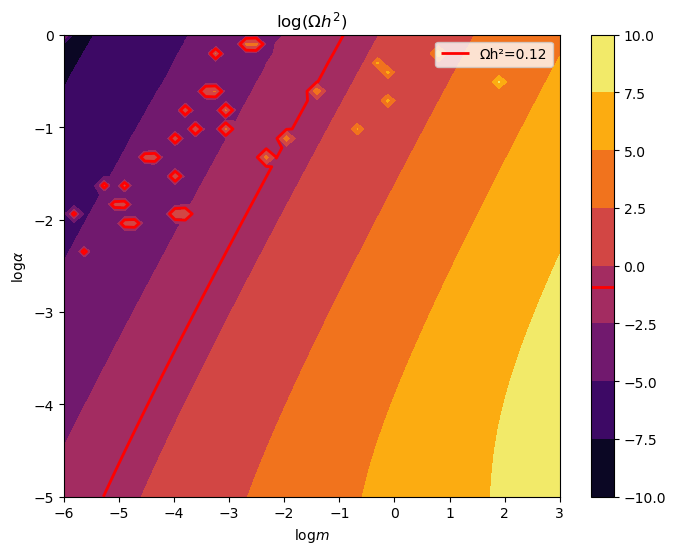

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Alphas,np.log10(Om_par_S),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='r',linestyles='solid',linewidths=2)
ax.set_title(r'$\mathrm{log}(\Omega h^2)$')
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\alpha$')
h1,_ = CSl.legend_elements()
ax.legend(h1,['Ωh²=0.12'])
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

$$Y_\infty=\sqrt{\dfrac{2}{\lambda}}x_f^2$$

where $\lambda=-\langle\sigma v^2\rangle\dfrac{\alpha^2}{\beta}m^4,~\alpha=\dfrac{2\pi^2}{45}g_{\star S},~\beta=\sqrt{\dfrac{\pi^2}{90M_P^2}g_\star}$ and $x_f$ is the solution to $e^{-2x_f}=\dfrac{x_f^2}{k^2\lambda c(c+1)^2}$, $k=0.145\dfrac{g}{g_{\star S}}$

$$\Omega_{DM}h^2=\dfrac{Y_0ms_0}{3M_P^2(2.13\times 10^{-42}\text{ GeV})^2}$$

### Long-lived relativistic particle

$$\begin{align*}
\dfrac{\mathrm{d}n_\phi}{\mathrm{d}t}+3Hn_\phi&=-\Gamma_\phi n_\phi\\
\dfrac{\mathrm{d}\rho_R}{\mathrm{d}t}+4H\rho_R&=+\Gamma_\phi n_\phi m_\phi\\
H&=\sqrt{\dfrac{\rho_R+m_\phi n_\phi}{3M_P^2}}
\end{align*}$$

Using $R=\rho_Ra^4$ and $\Phi=n_\phi a^3$:

$$\begin{align*}
\dfrac{\mathrm{d}\Phi}{\mathrm{d}t}&=-\Gamma_\phi\Phi\\
\dfrac{\mathrm{d}R}{\mathrm{d}t}&=\Gamma_\phi\Phi am_\phi\\
\dfrac{\mathrm{d}a}{\mathrm{d}t}&=\sqrt{\dfrac{R+\Phi m_\phi a}{3M_P^2}}a^{-2}\\
\end{align*}

In [54]:
def dVda(a,V,mass,Gamma):
    Phi, R = V
    H = ((R+Phi*a*mass)/(3*MP**2))**0.5*a**-2
    dPhida = -Gamma*Phi/(a*H)
    dRda = Gamma*mass*Phi/H
    dVda = [dPhida,dRda]
    return dVda

In [55]:
a0 = 1.
afin = 1e15
V0_rh = [1e15,0.]
mass = 10.
sol_rh = solve_ivp(dVda,[a0,afin],V0_rh,method='BDF',rtol=1e-8,atol=1e-10,args=(mass,1e-24))

rho_R_rh = sol_rh.y[1]*sol_rh.t**-4
rho_phi_rh = mass*sol_rh.y[0]*sol_rh.t**-3

delta_rho_rh = rho_R_rh-rho_phi_rh

for i in range(len(delta_rho_rh)-1):
    if delta_rho_rh[i]*delta_rho_rh[i+1]<0:
        a_rh = sol_rh.t[i]



In [56]:
T_rh = (30/np.pi**2*1/gstar*sol_rh.y[1]*sol_rh.t**-4)**1/4

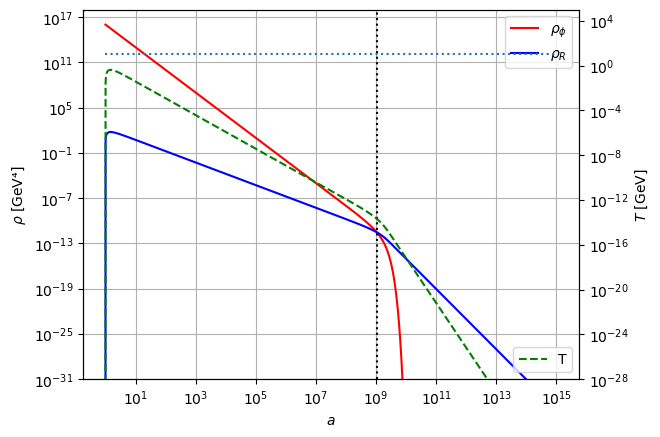

In [57]:
fig, ax1 = plt.subplots()

ax1.loglog(sol_rh.t,rho_phi_rh,color='r',label=r'$\rho_\phi$')
ax1.loglog(sol_rh.t,rho_R_rh,color='b',label=r'$\rho_R$')
ax1.vlines(a_rh,1e-31,1e18,colors='k',linestyles='dotted')
ax1.set_ylabel(r'$\rho$ [GeV⁴]')
ax1.set_xlabel(r'$a$')
ax1.set_ylim(1e-31,1e18)
ax1.legend()
ax1.grid()

ax2 = ax1.twinx()

ax2.loglog(sol_rh.t,T_rh,'g--',label='T')
ax2.set_ylim((1e-28,1e5))
ax2.legend(loc='lower right')
ax2.set_ylabel(r'$T$ [GeV]')
ax2.hlines(mass,1,1e15,linestyles='dotted')
plt.show()

In [58]:
V0_emd = [1.,100]
mass = 10
sol_emd = solve_ivp(dVda,[a0,afin],V0_emd,method='BDF',rtol=1e-8,atol=1e-10,args=(mass,1e-24))

rho_R_emd = sol_emd.y[1]*sol_emd.t**-4
rho_phi_emd = mass*sol_emd.y[0]*sol_emd.t**-3

delta_rho_emd = rho_R_emd-rho_phi_emd

a_emd = []
for i in range(len(delta_rho_emd)-1):
    if delta_rho_emd[i]*delta_rho_emd[i+1]<0:
        a_emd.append(sol_emd.t[i])

In [59]:
T_emd = (30/np.pi**2*1/gstar*sol_emd.y[1]*sol_emd.t**-4)**1/4

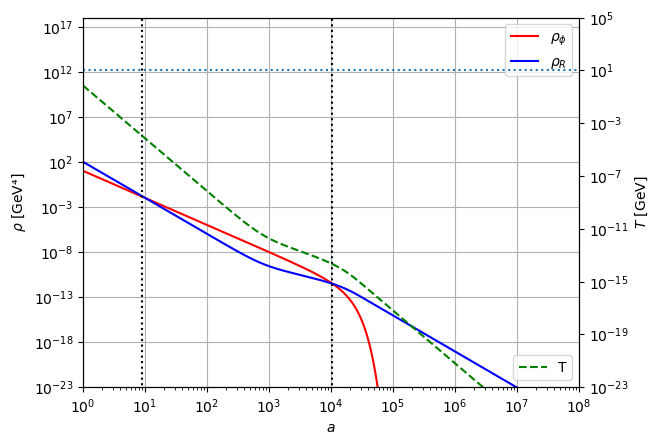

In [60]:
fig, ax1 = plt.subplots()

ax1.loglog(sol_emd.t,rho_phi_emd,color='r',label=r'$\rho_\phi$')
ax1.loglog(sol_emd.t,rho_R_emd,color='b',label=r'$\rho_R$')
ax1.vlines(a_emd,1e-31,1e18,colors='k',linestyles='dotted')
ax1.set_ylabel(r'$\rho$ [GeV⁴]')
ax1.set_xlabel(r'$a$')
ax1.set_ylim(1e-23,1e18)
ax1.set_xlim(1,1e8)
ax1.legend()
ax1.grid()

ax2 = ax1.twinx()

ax2.loglog(sol_emd.t,T_emd,'g--',label='T')
ax2.set_ylim((1e-23,1e5))
ax2.legend(loc='lower right')
ax2.set_ylabel(r'$T$ [GeV]')
ax2.hlines(mass,1,1e15,linestyles='dotted')
plt.show()

$$
\dfrac{\mathrm{d}N}{\mathrm{d}a}=-\langle\sigma v\rangle\dfrac{N^2-N_{eq}^2}{Ha^4}
$$

$$
N_{eq}=a^3\dfrac{g}{2\pi^2}m^2\dfrac{T_0}{a}K_2\left(\dfrac{ma}{T_0}\right)
$$

In [61]:
def dNda(a,N,mass,sigma,g,T0):
    Neq = a**2*g/(2*np.pi**2)*T0*kn(2,mass*a/T0)
    H = (np.pi**2*gstar/(90*MP**2))**0.5*(T0/a)**2
    dNda = -sigma*(N**2-Neq**2)/(H*a**4)
    return dNda

In [62]:
def graf7(mass,sigma,g):
    aini = 1.
    T0 = mass/0.1
    afin = 1e10
    Nini = g/(2*np.pi**2)*T0*kn(2,mass/T0)
    sol = solve_ivp(dNda, [aini,afin], [Nini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g,T0))
    plt.loglog(sol.t,sol.y[0],color='r')
    #plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
    #plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    #plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    #plt.ylim(2e-8,1e-2)
    plt.title('Boltzmann equation for WIMPs')
    plt.xlabel('a')
    plt.ylabel('N')
    plt.grid()
    #plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=3,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-25, max=-10,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot7 = interactive(graf7, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot7

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-3.0, step=0.0001), FloatLo…